In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

data= pd.read_csv("/content/cyberbullying_tweets.csv")

In [3]:
data["label"]= data["cyberbullying_type"].apply(lambda x: int(x!= "not_cyberbullying"))

In [4]:
data.head()

,tweet_text,cyberbullying_type,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0


**Phase 1: EDA to see distribution of** **Tweets**

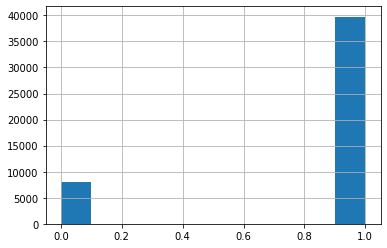

In [ ]:
#Distribution of tweets
data.label.hist() #Histogram shows that the dataset is balanced and has equal representation for all labels

In [ ]:
temp = data.groupby('label').count().reset_index().sort_values(by='tweet_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,tweet_text,cyberbullying_type
1,1,39747,39747
0,0,7945,7945


In [ ]:
#Funnel-Chart for better visualization
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp,
    values = temp.tweet_text,
    title = {"position": "top center", "text": "Funnel-Chart of Bullying Type Distribution"}
    ))
fig.show()

**Word Cloud of tweets for EDA**

In [ ]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
text = " ".join(review for review in data.tweet_text)

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update([])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

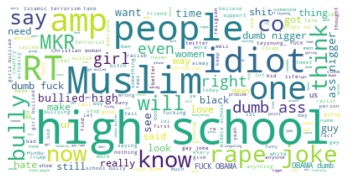

In [ ]:
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

**Phase 2: Building a base model for multi-class classification**

**TEXT PREPROCESSING** functions defintion:

In [ ]:
# import TweetTokenizer() method from nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Create a reference variable for Class WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Create a reference variable for Class TweetTokenizer
tk = TweetTokenizer()

#Preprocessing: Tweet Tokenizer + lowercase conversion
def LC_tokeniser(df):
  df["tokens"]= df["tweet_text"].apply(lambda x: tk.tokenize(x.lower()))
  return df
#Recover Hashtags
def hashtag(df):
  df["hastags"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("#")])
  return df
#Recover Mentions @
def mentions(df):
  df["mentions"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("@")])
  return df
#number of words in a tweet
def length(df):
  df["length"]= df["tokens"].apply(lambda x: len(x))
  return df

#Remove Stop-words
def remove_stopwords(df):
  df['remove_stopwords'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop_words])
  return df

#Lemmatisation to get root words and remove numbers if any!
def lemmatise(df):
  df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x if y.isalpha()]) 
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data.head()

,tweet_text,cyberbullying_type,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0


In [ ]:
#Function definition for Topic Modelling based on tweet's comments
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def LDA(df, n=10):
  # initisalise LDA Model
  lda_model = LatentDirichletAllocation(n_components = n, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )
  vectors = []
  for index, row in data.iterrows():
    vectors.append(", ".join(row[6]))
  
  vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
  vectorised = vectorizer.fit_transform(vectors)
  
  lda_output = lda_model.fit_transform(vectorised)

# column names
  topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
  df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
  dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
  df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
  df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
  df['Dominant_topic']=df['Dominant_topic'].astype(int)

  return df

Feature Engineering - BOWs and TF-IDF

**Feature Engineering**

Split data into train and test

In [ ]:
from sklearn.model_selection import train_test_split
df= LC_tokeniser(data)
del(data)
df= hashtag(df)
df= mentions(df)
df= length(df)
df= remove_stopwords(df)
df= lemmatise(df)
df["hashtags_present"]=df["hastags"].apply(lambda x: int((len(x)>0)))
df["mentions_present"]= df["mentions"].apply(lambda x:int((len(x)>0)))
df.head()

,tweet_text,cyberbullying_type,label,tokens,hastags,mentions,length,remove_stopwords,lemmatise,hashtags_present,mentions_present
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",[],11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",1,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",[],15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],1,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],[@xochitlsuckkks],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0,1
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],[@jason_gio],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0,1
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,"[@rudhoeenglish, this, is, an, isis, account, ...",[],[@rudhoeenglish],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0,1


In [ ]:
#Bag of Vectors
from sklearn.feature_extraction.text import CountVectorizer
def bow(df):
  vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
  # join the processed data to be vectorised
  vectors = []
  for index, row in data.iterrows():
    vectors.append(", ".join(row[6]))

  vectorised = vectorizer.fit_transform(vectors)
  return vectorised

In [ ]:
df["lemma_sentence"]= df["lemmatise"].apply(lambda x: " ".join(str(w) for w in x))
df.head()

,tweet_text,cyberbullying_type,label,tokens,hastags,mentions,length,remove_stopwords,lemmatise,hashtags_present,mentions_present,lemma_sentence
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",[],11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",1,0,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",[],15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],1,0,white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],[@xochitlsuckkks],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0,1,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],[@jason_gio],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0,1,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,"[@rudhoeenglish, this, is, an, isis, account, ...",[],[@rudhoeenglish],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0,1,isi account pretending kurdish account like is...


In [ ]:
print("Duplicate tweets:",df["lemma_sentence"].duplicated().sum())
df.drop_duplicates("lemma_sentence", inplace=True)

Duplicate tweets: 3312


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44380 entries, 0 to 47691
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          44380 non-null  object
 1   cyberbullying_type  44380 non-null  object
 2   label               44380 non-null  int64 
 3   tokens              44380 non-null  object
 4   hastags             44380 non-null  object
 5   mentions            44380 non-null  object
 6   length              44380 non-null  int64 
 7   remove_stopwords    44380 non-null  object
 8   lemmatise           44380 non-null  object
 9   hashtags_present    44380 non-null  int64 
 10  mentions_present    44380 non-null  int64 
 11  lemma_sentence      44380 non-null  object
dtypes: int64(4), object(8)
memory usage: 4.4+ MB


In [ ]:
x = df.iloc[:,3:12]
y = df['label']

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44380 entries, 0 to 47691
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tokens            44380 non-null  object
 1   hastags           44380 non-null  object
 2   mentions          44380 non-null  object
 3   length            44380 non-null  int64 
 4   remove_stopwords  44380 non-null  object
 5   lemmatise         44380 non-null  object
 6   hashtags_present  44380 non-null  int64 
 7   mentions_present  44380 non-null  int64 
 8   lemma_sentence    44380 non-null  object
dtypes: int64(3), object(6)
memory usage: 3.4+ MB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
text_features=  tfidf.fit_transform(x.lemma_sentence).toarray()
labels = y
print(text_features.shape)
print(tfidf.get_feature_names_out())

(44380, 15751)
['aa' 'aaaand' 'aap' ... 'zombie' 'zone' 'zoo']


In [ ]:
txt= pd.DataFrame(data= text_features, columns=tfidf.get_feature_names_out() )
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44380 entries, 0 to 44379
Columns: 15751 entries, aa to zoo
dtypes: float64(15751)
memory usage: 5.2 GB


In [ ]:
s= x.length.to_frame()
X= pd.concat([txt, s.set_index(txt.index)], axis=1)

In [ ]:
del(df)

In [ ]:
del(x)
X.head()

,aa,aaaand,aap,ab,abandon,abandoned,abc,abdul,abdul kalam,abe,...,zakir naik,zero,zero tolerance,zimmerman,zionist,zoe,zombie,zone,zoo,length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
del(X)

Base Model : Multinomial Naive Bayes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(x_train, y_train)

In [ ]:
clf.score(x_test,y_test)

0.8462145110410094

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred= clf.predict(x_test)

print("Classification report for Multinomial Naive Bayes:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for  Multinomial Naive Bayes:",accuracy_score(y_test, y_pred))

Classification report for Multinomial Naive Bayes:
               precision    recall  f1-score   support

           0       0.87      0.16      0.27      1575
           1       0.85      0.99      0.91      7301

    accuracy                           0.85      8876
   macro avg       0.86      0.58      0.59      8876
weighted avg       0.85      0.85      0.80      8876

Confusion Matrix: 
 [[ 247 1328]
 [  37 7264]]
Micro F1 score for  Multinomial Naive Bayes: 0.8462145110410094


**Decison trees**

Simple Decison tree:

In [ ]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier().fit(x_train, y_train)
clf_tree.score(x_test,y_test)

0.849594411897251

In [ ]:
y_pred= clf_tree.predict(x_test)

print("Classification report for Decision Tree Classifier:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for  DT classifier:",accuracy_score(y_test, y_pred))

Classification report for Decision Tree Classifier:
               precision    recall  f1-score   support

           0       0.58      0.54      0.56      1575
           1       0.90      0.92      0.91      7301

    accuracy                           0.85      8876
   macro avg       0.74      0.73      0.73      8876
weighted avg       0.85      0.85      0.85      8876

Confusion Matrix: 
 [[ 846  729]
 [ 606 6695]]
Micro F1 score for  DT classifier: 0.849594411897251


In [ ]:
del(clf)
del(clf_tree)

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       x_train:  4.2 GiB
                        x_test:  1.0 GiB
                          text: 25.0 MiB
                             y: 693.5 KiB
                        labels: 693.5 KiB
                             s: 693.5 KiB
                           ___: 615.5 KiB
                           _49: 615.5 KiB
                       y_train: 554.8 KiB
                        y_test: 138.7 KiB


In [ ]:
del(labels)
del(y)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

pgrid = {"max_depth": [1, 2, 3, 4, 5, 6, 7,10],
      "min_samples_split": [2, 3, 5, 10, 15, 20]}
random_search = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_distributions=pgrid, cv=5)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.best_estimator_.score(x_test, y_test))

#grid_search = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=pgrid, cv=10)
#grid_search.fit(x_train, y_train)
#print(grid_search.best_params_)
#print(grid_search.best_estimator_.score(x_test, y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RF= RandomForestClassifier(n_estimators=200, random_state=42).fit(x_train, y_train)
clf_RF.score(x_test,y_test)
clf_RF.score(x_test,y_test)

0.8682965299684543

In [ ]:
y_pred= clf_RF.predict(x_test)

print("Classification report for Random Forest Classifier:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for  Random Forest classifier:",accuracy_score(y_test, y_pred))

Classification report for Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.71      0.44      0.54      1575
           1       0.89      0.96      0.92      7301

    accuracy                           0.87      8876
   macro avg       0.80      0.70      0.73      8876
weighted avg       0.86      0.87      0.86      8876

Confusion Matrix: 
 [[ 686  889]
 [ 280 7021]]
Micro F1 score for  Random Forest classifier: 0.8682965299684543


In [ ]:
pgrid = {"max_depth": [1, 2, 3, 4, 5, 6, 7,10],"n_estimators": [10, 50, 100, 150, 200, 250]}
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=pgrid, cv=5)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print(random_search.best_estimator_.score(x_test, y_test))

In [ ]:
clf_RF_new= RandomForestClassifier(n_estimators=250, random_state=42).fit(x_train, y_train)
y_pred= clf_RF_new.predict(x_test)
print("Classification report for Random Forest Classifier:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for  Random Forest classifier:",accuracy_score(y_test, y_pred))

Classification report for Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.71      0.44      0.54      1575
           1       0.89      0.96      0.92      7301

    accuracy                           0.87      8876
   macro avg       0.80      0.70      0.73      8876
weighted avg       0.86      0.87      0.86      8876

Confusion Matrix: 
 [[ 688  887]
 [ 282 7019]]
Micro F1 score for  Random Forest classifier: 0.8682965299684543


In [34]:
data= pd.read_csv("/content/cyberbullying_tweets.csv")

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
x = data['tweet_text']
y = data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((38153,), (9539,), (38153,), (9539,))

In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Model_sgd = Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
Model_sgd.fit(x_train, y_train)
Model_sgd.score(x_test, y_test)

y_pred = Model_sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8357270154104204
              precision    recall  f1-score   support

           0       0.77      0.05      0.09      1624
           1       0.84      1.00      0.91      7915

    accuracy                           0.84      9539
   macro avg       0.80      0.52      0.50      9539
weighted avg       0.82      0.84      0.77      9539



In [23]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfTransformer
Modelxgb = Pipeline([('vect', CountVectorizer(stop_words='english')),('tfidf', TfidfTransformer()), ("clf", XGBClassifier(n_estimators=400))])
Modelxgb.fit(x_train, y_train)
Modelxgb.score(x_test, y_test)

0.8689590103784464

In [24]:
y_pred= Modelxgb.predict(x_test)

print("Classification report for XGB:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for XGB:",accuracy_score(y_test, y_pred))

Classification report for XGB:
               precision    recall  f1-score   support

           0       0.76      0.34      0.47      1624
           1       0.88      0.98      0.93      7915

    accuracy                           0.87      9539
   macro avg       0.82      0.66      0.70      9539
weighted avg       0.86      0.87      0.85      9539

Confusion Matrix: 
 [[ 552 1072]
 [ 178 7737]]
Micro F1 score for XGB: 0.8689590103784464


**Light GBM**

In [21]:
import lightgbm as lgb
model_lgbm = Pipeline([('vect', CountVectorizer(stop_words='english')),('tfidf', TfidfTransformer()), ("clf", lgb.LGBMClassifier(learning_rate=0.03,random_state=42,boosting_type="gbdt",n_estimators=400))])
model_lgbm.fit(x_train,y_train)
print('Training accuracy {:.4f}'.format(model_lgbm.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model_lgbm.score(x_test,y_test)))

Training accuracy 0.8960
Testing accuracy 0.8765


In [22]:
y_pred= model_lgbm.predict(x_test)

print("Classification report for XGB:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for XGB:",accuracy_score(y_test, y_pred))

Classification report for XGB:
               precision    recall  f1-score   support

           0       0.74      0.43      0.54      1624
           1       0.89      0.97      0.93      7915

    accuracy                           0.88      9539
   macro avg       0.81      0.70      0.74      9539
weighted avg       0.87      0.88      0.86      9539

Confusion Matrix: 
 [[ 696  928]
 [ 250 7665]]
Micro F1 score for XGB: 0.8765069713806478


**Ensemble Voting Classifier of Best predictors**

In [26]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

eclf = VotingClassifier(estimators=[('XGBoost', XGBClassifier()), ('RF', RandomForestClassifier(n_estimators=400)), ('MNB',MultinomialNB() ), ("SGD", SGDClassifier(alpha=1e-3, random_state=42, max_iter=5, tol=None)),("LightGBM",lgb.LGBMClassifier(learning_rate=0.03,random_state=42,boosting_type="gbdt",n_estimators=400))],voting='hard', weights=[3,2,1,1,3])
Model_Voting =  Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', eclf),
               ])
Model_Voting.fit(x_train, y_train)
y_pred= Model_Voting.predict(x_test)

print("Classification report for Ensemble Classifier':\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Ensemble Classifier:",accuracy_score(y_test, y_pred))

Classification report for Ensemble Classifier':
               precision    recall  f1-score   support

           0       0.76      0.38      0.50      1624
           1       0.88      0.98      0.93      7915

    accuracy                           0.87      9539
   macro avg       0.82      0.68      0.72      9539
weighted avg       0.86      0.87      0.86      9539

Confusion Matrix: 
 [[ 609 1015]
 [ 191 7724]]
Micro F1 score for Ensemble Classifier: 0.873571653213125
